In [2]:
# || Header ||
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy import stats
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import ipyvolume as ipv
import ipywidgets as widgets
from skimage import measure
import linecache
import math
import sys
sys.path.append('/u/home/k/kimvonga/python/')
import sm_fxns as sm
import dimer_dissoc_analysis as lib
import thf_dissoc_analysis as thf_lib
import plot_dimer_diss as plt_lib
import dimer_cavity as cav_lib
import Na2THF_clusters as ntb_fxns
from importlib import reload
plt.rcParams.update({'font.size': 14})

In [9]:
def genDistr(my_array, spacing=0.1):
    low = int(min(my_array)/spacing)*spacing
    high = math.ceil(max(my_array)/spacing)*spacing
    bins = np.arange(low, high, spacing)
    counts = np.zeros([len(bins),3])
    
    for i in range(len(my_array)):
        counts[int((my_array[i]-low)/spacing),1] += 1
    norm = np.sum(counts[:,1])
    print(norm)
    counts[:,2] = np.sqrt((counts[:,1]/norm)*(1-counts[:,1]/norm)/norm)*1.96
    counts[:,1] /= norm
    counts[:,0] = bins + spacing/2
    
    return counts

### Getting general sense of (4,5) and (5,5) gas phase behavior

OSError: /u/project/schwartz/kimvonga/Hoffman/Na2+_THF/liq/45init/diss/21/bondumb2.out not found.

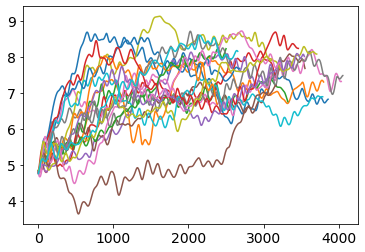

In [2]:
root = '/u/project/schwartz/kimvonga/Hoffman/Na2+_THF/liq/45init/diss/'
dirs = np.arange(1,21)

for i in dirs:
    my_dir = root+str(i)
    
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')
    plt.plot(bond_dist[:,0], bond_dist[:,1])

plt.xlim([0,5000])

(0.0, 10000.0)

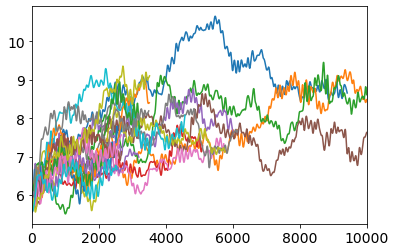

In [34]:
root = '/u/project/schwartz/kimvonga/Hoffman/Na2+_THF/liq/55init/diss/'
dirs = np.arange(1,21)

for i in dirs:
    my_dir = root+str(i)
    
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')
    plt.plot(bond_dist[:,0], bond_dist[:,1])

plt.xlim([0,10000])

(0.0, 3000.0)

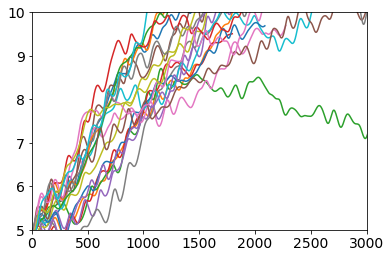

In [4]:
root = '/u/project/schwartz/kimvonga/Hoffman/Na2+_THF/cluster/45/'
dirs = np.arange(1,21)

for i in dirs:
    my_dir = root+str(i)
    
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')
    plt.plot(bond_dist[:,0], bond_dist[:,1])

plt.ylim([5,10])
plt.xlim([0,3000])

(0.0, 3000.0)

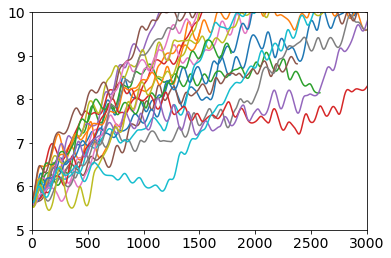

In [26]:
root = '/u/project/schwartz/kimvonga/Hoffman/Na2+_THF/cluster/55/'
dirs = np.arange(1,21)

for i in dirs:
    my_dir = root+str(i)
    
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')
    plt.plot(bond_dist[:,0], bond_dist[:,1], label=str(i))

plt.ylim([5,10])
plt.xlim([0,3000])

<IPython.core.display.Javascript object>


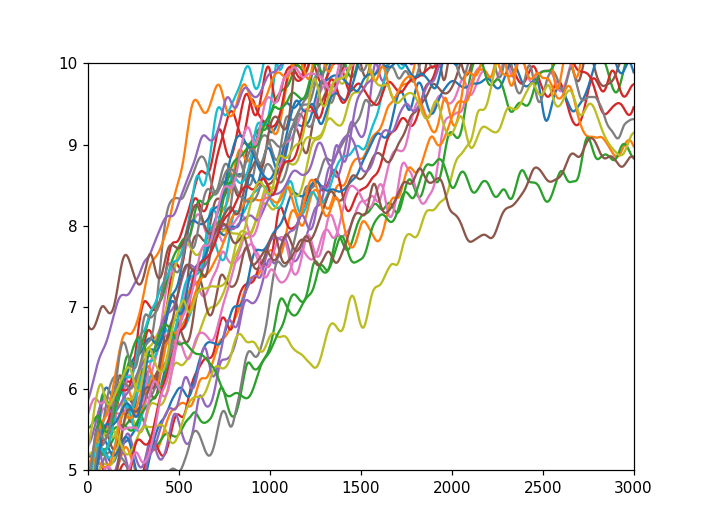

(0.0, 3000.0)

In [7]:
#4,5 cluster traj 1 - 39
%matplotlib notebook
root = '/u/home/k/kmei94/project-schwartz/Na2/dynamic/cluster/45/'
dirs = np.arange(1,40)

for i in dirs:
    my_dir = root+str(i)
    
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')
    plt.plot(bond_dist[:,0], bond_dist[:,1])

plt.ylim([5,10])
plt.xlim([0,3000])

### Looking at particular cluster trajectory, starting as (4,5)

dictShellPts creates dictionary of solute positions, solvent positions, and electronic density

The cell commented with BoundedIntText widget then creates a widget allowing the user to visualize the positions as a function of time. Very helpful for visualizing the dynamics and how the interplay of solute and solvent positions affects the bonding electron

In [2]:
def dictShellPts(my_dir, t0, t, dt, num=1000, dens_file='density.cube', e_state=2, isoval=0.00025):
    r_Na = {}
    r_coordinated = {}
    verts = {}
    faces = {}
    
    t_frames = np.linspace(t0,t,num=int((t-t0)/dt+1),dtype='int')
    ngrid = int(linecache.getline(my_dir+dens_file, 4).split()[0])
    aulength = 0.529177208590000
    dx = float(linecache.getline(my_dir+dens_file, 4).split()[1])*aulength
    dy = float(linecache.getline(my_dir+dens_file, 5).split()[2])*aulength
    dz = float(linecache.getline(my_dir+dens_file, 6).split()[3])*aulength
    
    for i in range(len(t_frames)):
        my_Na, my_solv = thf_lib.readPos(my_dir+'out.conf', t_frames[i], n_solu=2)
        my_dens = thf_lib.readEDens(my_dir+dens_file, t_frames[i], e_state, auleng=aulength)[0]
#         my_verts, my_faces, _, _ = measure.marching_cubes_lewiner(np.reshape(my_dens[:,3],[ngrid,ngrid,ngrid],order='C'),level=isoval,
#                                                             spacing=(dx,dy,dz))
        my_verts, my_faces, _, _ = measure.marching_cubes(np.reshape(my_dens[:,3],[ngrid,ngrid,ngrid],order='C'),level=isoval,
                                                            spacing=(dx,dy,dz))
        offset = [dx*(ngrid-1)/2,dy*(ngrid-1)/2,dz*(ngrid-1)/2] + (my_Na[0,:]+my_Na[1,:])/2
        my_Na, my_solv, my_verts = lib.rotDimerEnv(my_Na, my_solv, my_verts-offset)
#        my_close = lib.closestAr(my_Na, my_solv[::5,:], n_cutoff=5, option='cation')

        r_Na[str(t_frames[i])] = my_Na
        r_coordinated[str(t_frames[i])] = my_solv
        verts[str(t_frames[i])] = my_verts
        faces[str(t_frames[i])] = my_faces
    
    return r_Na, r_coordinated, verts, faces

In [3]:
my_dir = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/30/'
t0 = 0; t = 240; dt = 80; N = 2
r_Na, r_coordinated, verts, faces = dictShellPts(my_dir, t0, t, dt, dens_file='density.cube')

In [8]:
# With BoundedIntText widget
t_frames = np.linspace(t0,t,num=int((t-t0)/dt+1),dtype='int')
my_Na = r_Na[str(t_frames[0])]; my_coordinated = r_coordinated[str(t_frames[0])]
my_verts = verts[str(t_frames[0])]; my_faces = faces[str(t_frames[0])]

fig = ipv.figure()

ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=10, color='#000000', marker='circle_2d')
ipv.scatter(my_coordinated[::5,0], my_coordinated[::5,1], my_coordinated[::5,2], size=8, color='green', marker='circle_2d')
ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
# ipv.scatter(my_close[::5,0], my_close[::5,1], my_close[::5,2], size=8, color='green', marker='circle_2d')
# ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=4, color='red', marker='circle_2d')
# ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=1 ,color='#1f77b4', marker='circle_2d')
# ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=1, color='#1f77b4', marker='circle_2d')

ipv.xyzlim(-5,5)
ipv.show()

a=widgets.BoundedIntText(value=t0, min=t0, max=t, step=dt, description='Time (fs):')
def f(x):
    my_Na = r_Na[str(x)]; my_coordinated = r_coordinated[str(x)]
    my_verts = verts[str(x)]; my_faces = faces[str(x)]
#     my_vacant = vacant[str(x)]; my_occupied = occupied[str(x)]
#     my_close = close[str(x)]; my_closest = closest[str(x)]
    fig.scatters.clear()
    fig.meshes.clear()
    
    ipv.scatter(my_Na[:,0], my_Na[:,1], my_Na[:,2], size=10, color='#000000', marker='circle_2d')
    ipv.scatter(my_coordinated[::5,0], my_coordinated[::5,1], my_coordinated[::5,2], size=8, color='green', marker='circle_2d')
    ipv.plot_trisurf(my_verts[:,0], my_verts[:,1], my_verts[:,2], triangles=my_faces, color='#00ff00C1')
#     ipv.scatter(my_close[::5,0], my_close[::5,1], my_close[::5,2], size=8, color='green', marker='circle_2d')
#     ipv.scatter(my_closest[:,0], my_closest[:,1], my_closest[:,2], size=4, color='red', marker='circle_2d')
#     ipv.scatter(my_vacant[:,0], my_vacant[:,1], my_vacant[:,2], size=1 ,color='#1f77b4', marker='circle_2d')
#     ipv.scatter(my_occupied[:,0], my_occupied[:,1], my_occupied[:,2], size=1, color='red', marker='circle_2d')
    
    ipv.xyzlim(-5,5)
    
w = widgets.interact(f, x=a)

interactive(children=(BoundedIntText(value=0, description='Time (fs):', max=240, step=80), Output()), _dom_cla…

my_dir = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/1/'

In [87]:
my_dir = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/1/'
(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

internal_angles_Na1 = np.zeros([len(t_frames),7])
internal_angles_Na2 = np.zeros([len(t_frames),11])
coord_num = np.zeros([len(t_frames), 3])
node_angle = np.zeros([len(t_frames), 2])
mol_geo = np.zeros([len(t_frames), 3])
E_internal = np.zeros([len(t_frames), 2])

bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4)]
U_internal = np.loadtxt(my_dir+'/out.energies_mf')[int(t0/4):int(t/4+1):int(dt/4),[0,2,7,8,9]]
quant_e = np.loadtxt(my_dir+'/out.quante2')[int(t0/4):int(t/4+1):int(dt/4),:2]
dipole = np.loadtxt(my_dir+'/out.dip')[int(t0/4):int(t/4+1):int(dt/4),3:6]
dipole = np.insert(dipole, 0, np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4),0], axis=1)
for i in range(len(t_frames)):
    r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[i])

    # calculating coord num
    coord_num[i,1:] = thf_lib.calcCoordNum(r_Na, r_THF, r_cutoff=3.65, kappa=0.2, n_solu=2)

    # calculating dipole angle
    # first check time
    if t_frames[i] != dipole[i,0]:
        print('times do not match. t_frames[i] = '+str(t_frames[i])+'; dipole[i,0] = '+str(dipole[i,0]))
        break
    else:
        node_angle[i,1] = thf_lib.calcNodeAngle(r_Na, dipole[i,1:])

    # calculating molecular geometry
    coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
    na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
    na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
    internal_angles_Na1[i,1:] = thf_lib.calcInternalAngles(r_Na[0], r_THF[na1_indices])
    internal_angles_Na2[i,1:] = thf_lib.calcInternalAngles(r_Na[1], r_THF[na2_indices])
    mol_geo[i,1] = thf_lib.calcMolGeo(r_Na[0], r_THF[na1_indices])
    mol_geo[i,2] = thf_lib.calcMolGeo(r_Na[1], r_THF[na2_indices])
    
    # Internal energy, by calculating. Checks out!
#    E_internal[i,1] = thf_lib.calcUNaNa(r_Na[0], r_Na[1])
    for j in range(int(len(r_THF)/5)):
        E_internal[i,1] += thf_lib.calcUNaTHF(r_Na[0], r_THF[5*j:5*(j+1)])
        E_internal[i,1] += thf_lib.calcUNaTHF(r_Na[1], r_THF[5*j:5*(j+1)])
    for j in range(int(len(r_THF)/5-1)):
        for k in range(j+1,int(len(r_THF)/5)):
            E_internal[i,1] += thf_lib.calcUTHFTHF(r_THF[5*j:5*(j+1)], r_THF[5*k:5*(k+1)])

coord_num[:,0] = t_frames
node_angle[:,0] = t_frames
internal_angles_Na1[:,0] = t_frames
internal_angles_Na2[:,0] = t_frames
mol_geo[:,0] = t_frames
E_internal[:,0] = t_frames

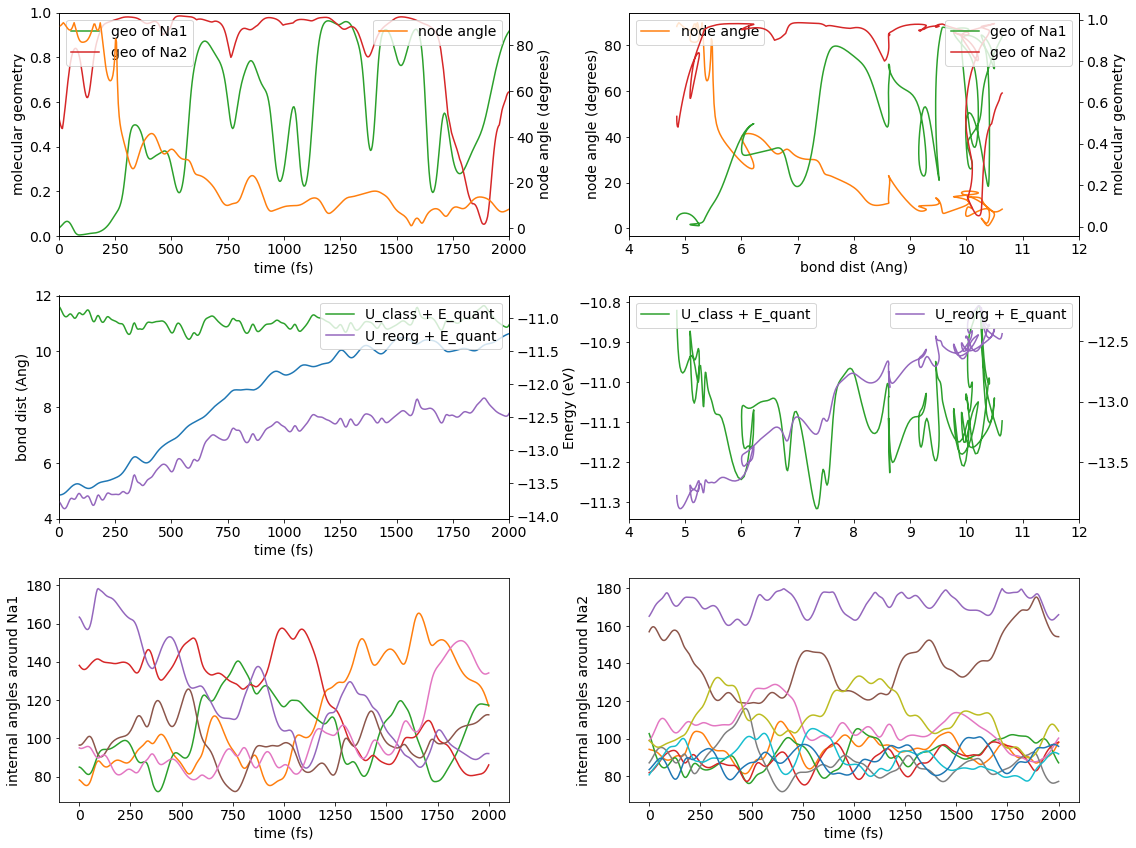

In [88]:
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.plot(mol_geo[:,0], mol_geo[:,1], label='geo of Na1', color='C2')
plt.plot(mol_geo[:,0], mol_geo[:,2], label='geo of Na2', color='C3')
plt.legend(loc=2)
plt.ylabel('molecular geometry')
plt.ylim([0,1])
plt.xlim([0,2000])
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(node_angle[:,0], node_angle[:,1], 'C1', label='node angle')
plt.ylabel('node angle (degrees)')
plt.legend(loc=1)
# plt.ylim([0,90])

plt.subplot(3,2,2)
plt.plot(bond_dist[:,1], node_angle[:,1], label='node angle', color='C1')
plt.legend(loc=2)
plt.xlim([4,12])
plt.ylabel('node angle (degrees)')
plt.xlabel('bond dist (Ang)')

plt.twinx()
plt.plot(bond_dist[:,1], mol_geo[:,1], label='geo of Na1', color='C2')
plt.plot(bond_dist[:,1], mol_geo[:,2], label='geo of Na2', color='C3')
plt.legend(loc=1)
plt.ylabel('molecular geometry')

plt.subplot(3,2,3)
plt.plot(bond_dist[:,0], bond_dist[:,1])
plt.ylim([4,12])
plt.xlim([0,2000])
plt.ylabel('bond dist (Ang)')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(quant_e[:,0], quant_e[:,1] + U_internal[:,1], label='U_class + E_quant', color='C2')
plt.plot(quant_e[:,0], quant_e[:,1] + E_internal[:,1], label='U_reorg + E_quant', color='C4')
plt.legend(loc=1)
plt.ylabel('Energy (eV)')

plt.subplot(3,2,4)
plt.plot(bond_dist[:,1], quant_e[:,1] + U_internal[:,1], label='U_class + E_quant', color='C2')
plt.legend(loc=2)
plt.twinx()
plt.plot(bond_dist[:,1], quant_e[:,1] + E_internal[:,1], label='U_reorg + E_quant', color='C4')
plt.legend(loc=1)
plt.xlabel('bond dist (Ang)')
plt.xlim([4,12])

plt.subplot(3,2,5)
for i in range(1,7):
    plt.plot(internal_angles_Na1[:,0], internal_angles_Na1[:,i], color='C'+str(i))
plt.xlabel('time (fs)')
plt.ylabel('internal angles around Na1')
    
plt.subplot(3,2,6)
for i in range(1,11):
    plt.plot(internal_angles_Na2[:,0], internal_angles_Na2[:,i], color='C'+str(i))
plt.xlabel('time (fs)')
plt.ylabel('internal angles around Na2')

plt.tight_layout()

trying with square planar as other ref geometry for Na1. seesaw would coorespond to 0.5 according to this order parameter

In [90]:
my_dir = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/1/'
(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

internal_angles_Na1 = np.zeros([len(t_frames),7])
internal_angles_Na2 = np.zeros([len(t_frames),11])
coord_num = np.zeros([len(t_frames), 3])
node_angle = np.zeros([len(t_frames), 2])
mol_geo = np.zeros([len(t_frames), 3])
E_internal = np.zeros([len(t_frames), 2])

bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4)]
U_internal = np.loadtxt(my_dir+'/out.energies_mf')[int(t0/4):int(t/4+1):int(dt/4),[0,2,7,8,9]]
quant_e = np.loadtxt(my_dir+'/out.quante2')[int(t0/4):int(t/4+1):int(dt/4),:2]
dipole = np.loadtxt(my_dir+'/out.dip')[int(t0/4):int(t/4+1):int(dt/4),3:6]
dipole = np.insert(dipole, 0, np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4),0], axis=1)
for i in range(len(t_frames)):
    r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[i])

    # calculating coord num
    coord_num[i,1:] = thf_lib.calcCoordNum(r_Na, r_THF, r_cutoff=3.65, kappa=0.2, n_solu=2)

    # calculating dipole angle
    # first check time
    if t_frames[i] != dipole[i,0]:
        print('times do not match. t_frames[i] = '+str(t_frames[i])+'; dipole[i,0] = '+str(dipole[i,0]))
        break
    else:
        node_angle[i,1] = thf_lib.calcNodeAngle(r_Na, dipole[i,1:])

    # calculating molecular geometry
    coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
    na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
    na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
    internal_angles_Na1[i,1:] = thf_lib.calcInternalAngles(r_Na[0], r_THF[na1_indices])
    internal_angles_Na2[i,1:] = thf_lib.calcInternalAngles(r_Na[1], r_THF[na2_indices])
    mol_geo[i,1] = thf_lib.calcMolGeo(r_Na[0], r_THF[na1_indices])
    mol_geo[i,2] = thf_lib.calcMolGeo(r_Na[1], r_THF[na2_indices])
    
    # Internal energy, by calculating. Checks out!
#    E_internal[i,1] = thf_lib.calcUNaNa(r_Na[0], r_Na[1])
    for j in range(int(len(r_THF)/5)):
        E_internal[i,1] += thf_lib.calcUNaTHF(r_Na[0], r_THF[5*j:5*(j+1)])
        E_internal[i,1] += thf_lib.calcUNaTHF(r_Na[1], r_THF[5*j:5*(j+1)])
    for j in range(int(len(r_THF)/5-1)):
        for k in range(j+1,int(len(r_THF)/5)):
            E_internal[i,1] += thf_lib.calcUTHFTHF(r_THF[5*j:5*(j+1)], r_THF[5*k:5*(k+1)])

coord_num[:,0] = t_frames
node_angle[:,0] = t_frames
internal_angles_Na1[:,0] = t_frames
internal_angles_Na2[:,0] = t_frames
mol_geo[:,0] = t_frames
E_internal[:,0] = t_frames

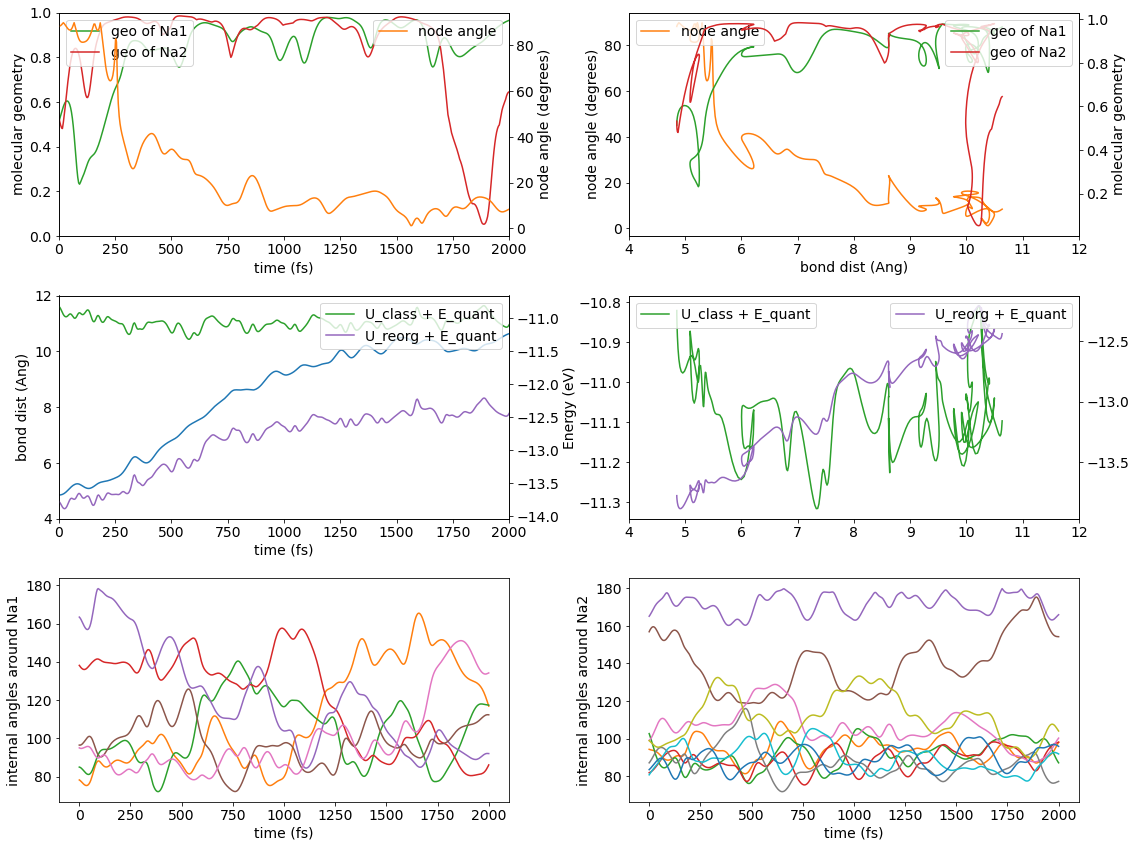

In [91]:
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.plot(mol_geo[:,0], mol_geo[:,1], label='geo of Na1', color='C2')
plt.plot(mol_geo[:,0], mol_geo[:,2], label='geo of Na2', color='C3')
plt.legend(loc=2)
plt.ylabel('molecular geometry')
plt.ylim([0,1])
plt.xlim([0,2000])
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(node_angle[:,0], node_angle[:,1], 'C1', label='node angle')
plt.ylabel('node angle (degrees)')
plt.legend(loc=1)
# plt.ylim([0,90])

plt.subplot(3,2,2)
plt.plot(bond_dist[:,1], node_angle[:,1], label='node angle', color='C1')
plt.legend(loc=2)
plt.xlim([4,12])
plt.ylabel('node angle (degrees)')
plt.xlabel('bond dist (Ang)')

plt.twinx()
plt.plot(bond_dist[:,1], mol_geo[:,1], label='geo of Na1', color='C2')
plt.plot(bond_dist[:,1], mol_geo[:,2], label='geo of Na2', color='C3')
plt.legend(loc=1)
plt.ylabel('molecular geometry')

plt.subplot(3,2,3)
plt.plot(bond_dist[:,0], bond_dist[:,1])
plt.ylim([4,12])
plt.xlim([0,2000])
plt.ylabel('bond dist (Ang)')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(quant_e[:,0], quant_e[:,1] + U_internal[:,1], label='U_class + E_quant', color='C2')
plt.plot(quant_e[:,0], quant_e[:,1] + E_internal[:,1], label='U_reorg + E_quant', color='C4')
plt.legend(loc=1)
plt.ylabel('Energy (eV)')

plt.subplot(3,2,4)
plt.plot(bond_dist[:,1], quant_e[:,1] + U_internal[:,1], label='U_class + E_quant', color='C2')
plt.legend(loc=2)
plt.twinx()
plt.plot(bond_dist[:,1], quant_e[:,1] + E_internal[:,1], label='U_reorg + E_quant', color='C4')
plt.legend(loc=1)
plt.xlabel('bond dist (Ang)')
plt.xlim([4,12])

plt.subplot(3,2,5)
for i in range(1,7):
    plt.plot(internal_angles_Na1[:,0], internal_angles_Na1[:,i], color='C'+str(i))
plt.xlabel('time (fs)')
plt.ylabel('internal angles around Na1')
    
plt.subplot(3,2,6)
for i in range(1,11):
    plt.plot(internal_angles_Na2[:,0], internal_angles_Na2[:,i], color='C'+str(i))
plt.xlabel('time (fs)')
plt.ylabel('internal angles around Na2')

plt.tight_layout()

In [9]:
my_dir = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/1/'
(t0, t, dt) = (0, 2000, 80)
t_frames = np.arange(t0, t+dt, dt)

e_distri = np.zeros([len(t_frames), 3])
for i in range(len(t_frames)):
    e_distri[i, 1:] = thf_lib.calcQSep(my_dir+'/density.cube', t_frames[i], nstate=2, r_cutoff=10)
e_distri[:,0] = t_frames

Text(0, 0.5, 'charge (e)')

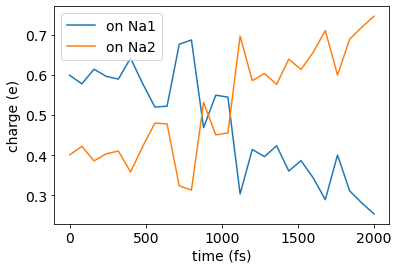

In [10]:
plt.plot(e_distri[:,0], e_distri[:,1], label='on Na1')
plt.plot(e_distri[:,0], e_distri[:,2], label='on Na2')
plt.legend(loc=2)
plt.xlabel('time (fs)')
plt.ylabel('charge (e)')

coordination number of Na1 against time for each trajectory

In [6]:
root = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/'
dirs = np.arange(24,25)

(t0, t, dt) = (0, 3000, 4)
t_frames = np.arange(t0, t+dt, dt)

coord_num_Na1 = np.zeros([len(dirs), len(t_frames)])
coord_num_Na2 = np.zeros([len(dirs), len(t_frames)])

for i in range(len(dirs)):
    my_dir = root+str(dirs[i])
    for t in range(len(t_frames)):
        r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[t])
        coord_num_Na1[i,t] = thf_lib.calcCoordNum(r_Na, r_THF)[0]
        coord_num_Na2[i,t] = thf_lib.calcCoordNum(r_Na, r_THF)[1]

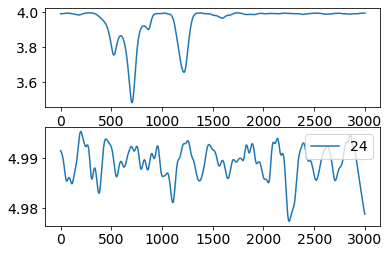

In [7]:
fig,axs = plt.subplots(2)

for i in range(len(dirs)):
    axs[0].plot(t_frames, coord_num_Na1[i,:], label=str(dirs[i]))
    axs[1].plot(t_frames, coord_num_Na2[i,:], label=str(dirs[i]))

plt.legend(loc=1)

calculating internal angles against time for ensemble of (4,5) cluster

In [ ]:
root = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/'
dirs = [1, 2, 3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
#dirs = np.arange(1,21)

(t0, t, dt) = (0, 3000, 4)
t_frames = np.arange(t0, t+dt, dt)

# assuming 4 THFs on Na1 and 5 THFs on Na2
avg_internal_angles_Na1 = np.zeros([len(t_frames), 7])
avg_internal_angles_Na2 = np.zeros([len(t_frames), 11])

internal_angles_Na1 = np.zeros([len(dirs), len(t_frames), 6])
internal_angles_Na2 = np.zeros([len(dirs), len(t_frames), 10])
for i in range(len(dirs)):
    my_dir = root+str(dirs[i])+'/'
    
    r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[0])
    coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
    na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
    na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
    
    my_angles_Na1 = thf_lib.calcInternalAngles(r_Na[0], r_THF[na1_indices])
    my_angles_Na2 = thf_lib.calcInternalAngles(r_Na[1], r_THF[na2_indices])
    
    order_Na1 = np.argsort(-my_angles_Na1)
    order_Na2 = np.argsort(-my_angles_Na2)
    
    if len(na1_indices) == 4:
        internal_angles_Na1[i,0,:] += my_angles_Na1[order_Na1]
        internal_angles_Na2[i,0,:] += my_angles_Na2[order_Na2]
    elif len(na1_indices) == 5:
        internal_angles_Na2[i,0,:] += my_angles_Na1[order_Na1]
        internal_angles_Na1[i,0,:] += my_angles_Na2[order_Na2]
    
    for t in range(1,len(t_frames)):
        r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[t])
        coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
        na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
        na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
        my_angles_Na1 = thf_lib.calcInternalAngles(r_Na[0], r_THF[na1_indices])
        my_angles_Na2 = thf_lib.calcInternalAngles(r_Na[1], r_THF[na2_indices])
        if len(na1_indices) == 4:
            internal_angles_Na1[i,t,:] += my_angles_Na1[order_Na1]
            internal_angles_Na2[i,t,:] += my_angles_Na2[order_Na2]
        elif len(na1_indices) == 5:
            internal_angles_Na2[i,t,:] += my_angles_Na1[order_Na1]
            internal_angles_Na1[i,t,:] += my_angles_Na2[order_Na2]
avg_internal_angles_Na1[:,1:] = np.average(internal_angles_Na1, axis=0)
avg_internal_angles_Na2[:,1:] = np.average(internal_angles_Na2, axis=0)
sem_internal_angles_Na1 = stats.sem(internal_angles_Na1, axis=0)
sem_internal_angles_Na2 = stats.sem(internal_angles_Na2, axis=0)
std_internal_angles_Na1 = np.std(internal_angles_Na1, axis=0)
std_internal_angles_Na2 = np.std(internal_angles_Na2, axis=0)
avg_internal_angles_Na1[:,0] = t_frames
avg_internal_angles_Na2[:,0] = t_frames

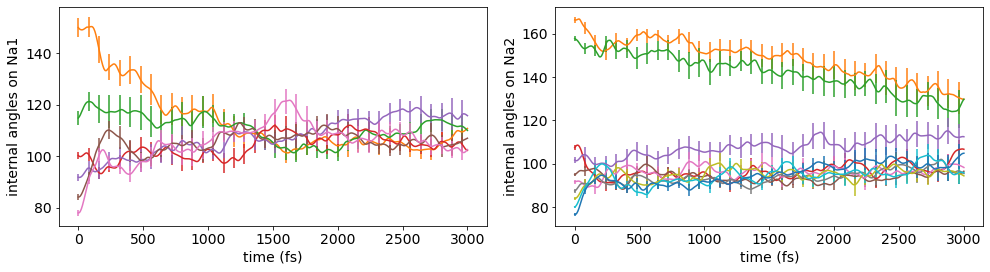

In [78]:
plt.figure(figsize=(14,4))
plt.subplot(1,2,1)
for i in range(1,7):
    plt.plot(avg_internal_angles_Na1[:,0], avg_internal_angles_Na1[:,i], color='C'+str(i))
    plt.errorbar(avg_internal_angles_Na1[::20,0], avg_internal_angles_Na1[::20,i], color='C'+str(i), yerr=sem_internal_angles_Na1[::20,i-1], linestyle='none')
plt.ylabel('internal angles on Na1')
plt.xlabel('time (fs)')

plt.subplot(1,2,2)
for i in range(1,11):
    plt.plot(avg_internal_angles_Na2[:,0], avg_internal_angles_Na2[:,i], color='C'+str(i))
    plt.errorbar(avg_internal_angles_Na2[::20,0], avg_internal_angles_Na2[::20,i],color='C'+str(i), yerr=sem_internal_angles_Na2[::20,i-1], linestyle='none')
plt.ylabel('internal angles on Na2')
plt.xlabel('time (fs)')

plt.tight_layout()

In [79]:
print('internal angles of Na1 (avg, sem)')
print(np.array([avg_internal_angles_Na1[-1,1:], sem_internal_angles_Na1[-1,:]]).T)
print('internal angles of Na2 (avg, sem)')
print(np.array([avg_internal_angles_Na2[-1,1:], sem_internal_angles_Na2[-1,:]]).T)

internal angles of Na1 (avg, sem)
[[110.75829677   3.93525441]
 [110.00735605   4.50962346]
 [102.25838687   2.40500124]
 [115.71755756   4.85660594]
 [106.97792077   3.13941955]
 [102.57287609   2.88530301]]
internal angles of Na2 (avg, sem)
[[129.72710677   7.21988882]
 [129.76920411   8.92968092]
 [106.68378089   4.60869786]
 [112.47777583   6.85372797]
 [ 96.56717511   3.84810069]
 [ 98.29882367   4.63030763]
 [ 95.53585788   5.64021254]
 [ 94.43452282   3.96156139]
 [ 95.87142553   5.13747255]
 [104.86951457   5.53632284]]


average angle appears to decrease for the initially large angles, while the third largest increases
but likely from indentity of antipodal THFs switching, so while average angle appears to diverge from trigonal bipyramid, geometry remains trigonal bipyramid

Want to get an idea of the square difference in angles. Calculating $\Sigma (\theta_i - \alpha_i)^2$

In [6]:
root = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/'
dirs = np.arange(1,21)

(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

sq_diff_angles = np.zeros([len(dirs), len(t_frames), 2])
mol_geo = np.zeros([len(dirs), len(t_frames), 2])
for d in range(len(dirs)):
    my_dir = root+str(dirs[d])
    for i in range(len(t_frames)):
        r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[i])

        # calculating sq diff
        coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
        na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
        na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
        if len(na1_indices) == 4:
            angles1 = thf_lib.calcInternalAngles(r_Na[0], r_THF[na1_indices])
            sq_diff_angles[d,i,0] = np.sum((angles1-109.47)**2)
            angles2 = -np.sort(-thf_lib.calcInternalAngles(r_Na[1], r_THF[na2_indices]))
            sq_diff_angles[d,i,1] = (angles2[0]-180)**2
            sq_diff_angles[d,i,1] += np.sum((angles2[1:4]-120)**2)
            sq_diff_angles[d,i,1] += np.sum((angles2[4:]-90)**2)
        elif len(na1_indices) == 5:
            angles2 = thf_lib.calcInternalAngles(r_Na[1], r_THF[na2_indices])
            sq_diff_angles[d,i,1] = np.sum((angles2-109.47)**2)
            angles1 = -np.sort(-thf_lib.calcInternalAngles(r_Na[0], r_THF[na1_indices]))
            sq_diff_angles[d,i,0] = (angles1[0]-180)**2
            sq_diff_angles[d,i,0] += np.sum((angles1[1:4]-120)**2)
            sq_diff_angles[d,i,0] += np.sum((angles1[4:]-90)**2)

Text(0.5, 0, 'time (fs)')

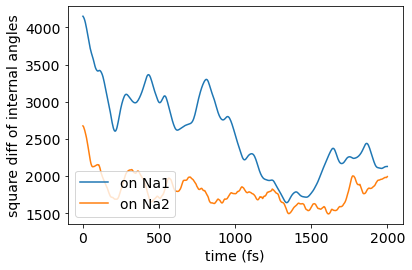

In [8]:
plt.plot(t_frames, np.average(sq_diff_angles[:,:,0], axis=0), 'C0', label='on Na1')
plt.plot(t_frames, np.average(sq_diff_angles[:,:,1], axis=0), 'C1', label='on Na2')
plt.legend(loc=3)
plt.ylabel('square diff of internal angles')
plt.xlabel('time (fs)')

In [15]:
distribution_Na2 = genDistr(np.average(sq_diff_angles[:,75:,1], axis=0), spacing=30)

426.0


<ErrorbarContainer object of 3 artists>

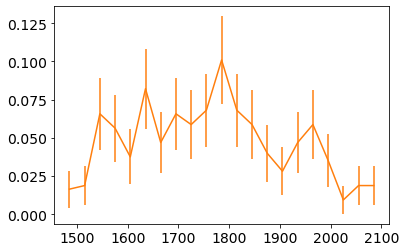

In [17]:
plt.errorbar(distribution_Na2[:,0], distribution_Na2[:,1], yerr=distribution_Na2[:,2], color='C1')

my_dir = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/2/'

In [13]:
my_dir = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/45/2/'
(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

coord_num = np.zeros([len(t_frames), 3])
node_angle = np.zeros([len(t_frames), 2])
mol_geo = np.zeros([len(t_frames), 3])
E_internal = np.zeros([len(t_frames), 2])

bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4)]
U_internal = np.loadtxt(my_dir+'/out.energies_mf')[int(t0/4):int(t/4+1):int(dt/4),[0,2,7,8,9]]
quant_e = np.loadtxt(my_dir+'/out.quante2')[int(t0/4):int(t/4+1):int(dt/4),:2]
dipole = np.loadtxt(my_dir+'/out.dip')[int(t0/4):int(t/4+1):int(dt/4),3:6]
dipole = np.insert(dipole, 0, np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4),0], axis=1)
for i in range(len(t_frames)):
    r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[i])

    # calculating coord num
    coord_num[i,1:] = thf_lib.calcCoordNum(r_Na, r_THF, r_cutoff=3.65, kappa=0.2, n_solu=2)

    # calculating dipole angle
    # first check time
    if t_frames[i] != dipole[i,0]:
        print('times do not match. t_frames[i] = '+str(t_frames[i])+'; dipole[i,0] = '+str(dipole[i,0]))
        break
    else:
        node_angle[i,1] = thf_lib.calcNodeAngle(r_Na, dipole[i,1:])

    # calculating molecular geometry
    coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
    na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
    na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
    mol_geo[i,1] = thf_lib.calcMolGeo(r_Na[0], r_THF[na1_indices])
    mol_geo[i,2] = thf_lib.calcMolGeo(r_Na[1], r_THF[na2_indices])
    
    # Internal energy, by calculating. Check out!
#     E_internal[i,1] = thf_lib.calcUNaNa(r_Na[0], r_Na[1])
    for j in range(int(len(r_THF)/5)):
        E_internal[i,1] += thf_lib.calcUNaTHF(r_Na[0], r_THF[5*j:5*(j+1)])
        E_internal[i,1] += thf_lib.calcUNaTHF(r_Na[1], r_THF[5*j:5*(j+1)])
    for j in range(int(len(r_THF)/5-1)):
        for k in range(j+1,int(len(r_THF)/5)):
            E_internal[i,1] += thf_lib.calcUTHFTHF(r_THF[5*j:5*(j+1)], r_THF[5*k:5*(k+1)])

coord_num[:,0] = t_frames
node_angle[:,0] = t_frames
mol_geo[:,0] = t_frames
E_internal[:,0] = t_frames

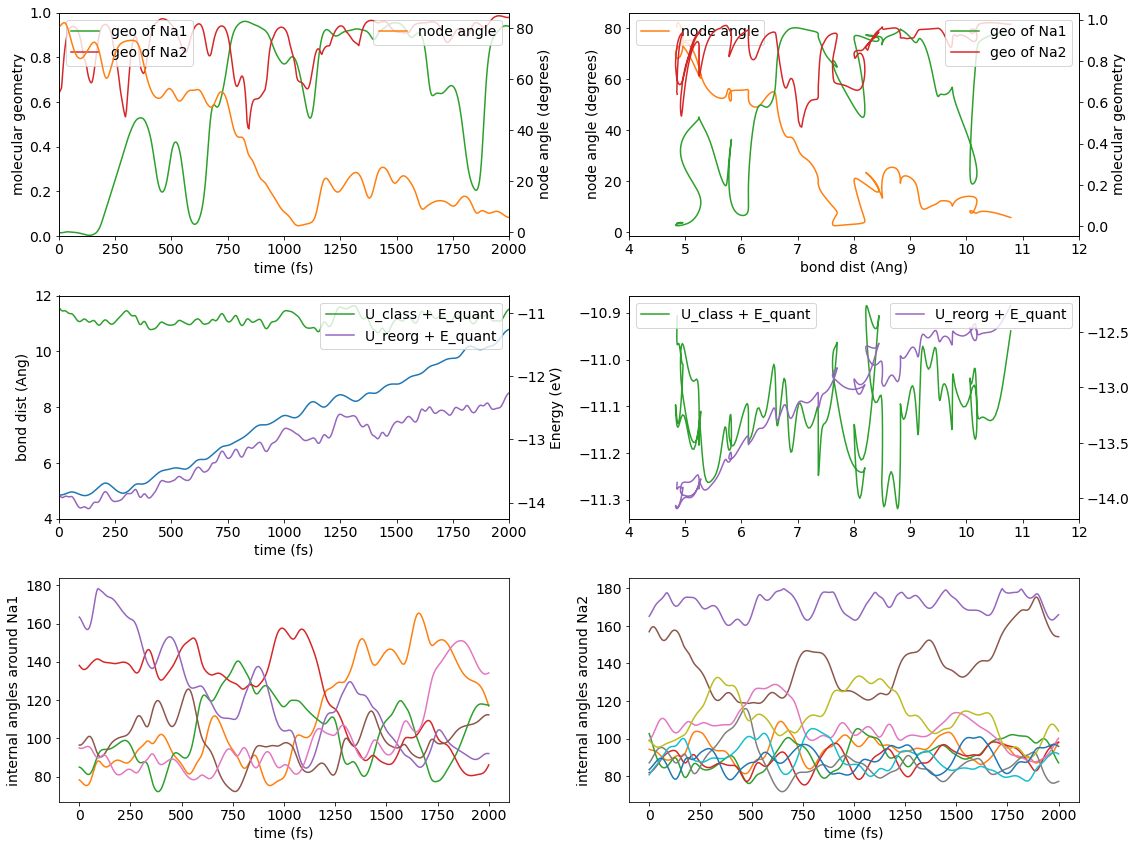

In [14]:
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.plot(mol_geo[:,0], mol_geo[:,1], label='geo of Na1', color='C2')
plt.plot(mol_geo[:,0], mol_geo[:,2], label='geo of Na2', color='C3')
plt.legend(loc=2)
plt.ylabel('molecular geometry')
plt.ylim([0,1])
plt.xlim([0,2000])
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(node_angle[:,0], node_angle[:,1], 'C1', label='node angle')
plt.ylabel('node angle (degrees)')
plt.legend(loc=1)
# plt.ylim([0,90])

plt.subplot(3,2,2)
plt.plot(bond_dist[:,1], node_angle[:,1], label='node angle', color='C1')
plt.legend(loc=2)
plt.xlim([4,12])
plt.ylabel('node angle (degrees)')
plt.xlabel('bond dist (Ang)')

plt.twinx()
plt.plot(bond_dist[:,1], mol_geo[:,1], label='geo of Na1', color='C2')
plt.plot(bond_dist[:,1], mol_geo[:,2], label='geo of Na2', color='C3')
plt.legend(loc=1)
plt.ylabel('molecular geometry')

plt.subplot(3,2,3)
plt.plot(bond_dist[:,0], bond_dist[:,1])
plt.ylim([4,12])
plt.xlim([0,2000])
plt.ylabel('bond dist (Ang)')
plt.xlabel('time (fs)')

plt.twinx()
plt.plot(quant_e[:,0], quant_e[:,1] + U_internal[:,1], label='U_class + E_quant', color='C2')
plt.plot(quant_e[:,0], quant_e[:,1] + E_internal[:,1], label='U_reorg + E_quant', color='C4')
plt.legend(loc=1)
plt.ylabel('Energy (eV)')

plt.subplot(3,2,4)
plt.plot(bond_dist[:,1], quant_e[:,1] + U_internal[:,1], label='U_class + E_quant', color='C2')
plt.legend(loc=2)
plt.twinx()
plt.plot(bond_dist[:,1], quant_e[:,1] + E_internal[:,1], label='U_reorg + E_quant', color='C4')
plt.legend(loc=1)
plt.xlabel('bond dist (Ang)')
plt.xlim([4,12])

plt.subplot(3,2,5)
for i in range(1,7):
    plt.plot(internal_angles_Na1[:,0], internal_angles_Na1[:,i], color='C'+str(i))
plt.xlabel('time (fs)')
plt.ylabel('internal angles around Na1')
    
plt.subplot(3,2,6)
for i in range(1,11):
    plt.plot(internal_angles_Na2[:,0], internal_angles_Na2[:,i], color='C'+str(i))
plt.xlabel('time (fs)')
plt.ylabel('internal angles around Na2')

plt.tight_layout()

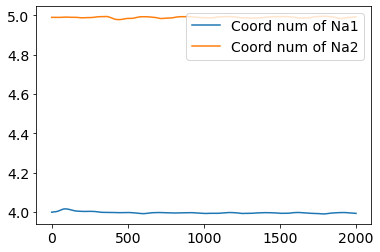

In [15]:
plt.plot(coord_num[:,0], coord_num[:,1], label='Coord num of Na1')
plt.plot(coord_num[:,0], coord_num[:,2], label='Coord num of Na2')
plt.legend(loc=1)

In [7]:
# coords of tetrahedron and trigonal bipyramid to verify calcMolGeo()
c4 = np.array([0,0,0])
v4 = np.array([[np.sqrt(8)/3, 0, -0.33], [-np.sqrt(2)/3, np.sqrt(2/3), -0.33], [-np.sqrt(2)/3, -np.sqrt(2/3), -0.33], [0, 0, 1]])

c5 = np.array([0,0,0])
v5 = np.array([[0,0,1], [0,0,-1], [0,-1,0], [np.sqrt(3)/2, 0.5,0], [-np.sqrt(3)/2,0.5,0]])

print(thf_lib.calcMolGeo(c4, v4), thf_lib.calcMolGeo(c5, v5))

0.9907561052273776 0.9912072837603251


Node angle looks good but molecular geometry oscillates quite a bit.
Want to check snapshots to get a better idea of the molecular geometry. 
Sum of classical potential and quantum energy appears to track well with node angle and molecular geometry for first 500 fs, but afterwards the sum of the energies lacks a trend.
    By 500 fs the bond distance is ~7 Ang.
    Check trend of energy with node angle, molecular geometry, and bond distance with the umbrella runs and then check that this energy is a decent proxy for PES

# Look at individual (5,5) trajectories


In [3]:
my_dir = '/u/project/schwartz/kmei94/Na2/dynamic/cluster/55/1/'
(t0, t, dt) = (0, 2000, 4)
t_frames = np.arange(t0, t+dt, dt)

coord_num = np.zeros([len(t_frames), 3])
node_angle = np.zeros([len(t_frames), 2])
mol_geo = np.zeros([len(t_frames), 3])
E_internal = np.zeros([len(t_frames), 2])

bond_dist = np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4)]
U_internal = np.loadtxt(my_dir+'/out.energies_mf')[int(t0/4):int(t/4+1):int(dt/4),[0,2,7,8,9]]
quant_e = np.loadtxt(my_dir+'/out.quante2')[int(t0/4):int(t/4+1):int(dt/4),:2]
dipole = np.loadtxt(my_dir+'/out.dip')[int(t0/4):int(t/4+1):int(dt/4),3:6]
dipole = np.insert(dipole, 0, np.loadtxt(my_dir+'/bondumb2.out')[int(t0/4):int(t/4+1):int(dt/4),0], axis=1)
for i in range(len(t_frames)):
    r_Na, r_THF = thf_lib.readPos(my_dir+'/out.conf', t_frames[i])

    # calculating coord num
    coord_num[i,1:] = thf_lib.calcCoordNum(r_Na, r_THF, r_cutoff=3.65, kappa=0.2, n_solu=2)

    # calculating dipole angle
    # first check time
    if t_frames[i] != dipole[i,0]:
        print('times do not match. t_frames[i] = '+str(t_frames[i])+'; dipole[i,0] = '+str(dipole[i,0]))
        break
    else:
        node_angle[i,1] = thf_lib.calcNodeAngle(r_Na, dipole[i,1:])

    # calculating molecular geometry
    coord_indices = thf_lib.findCoordIndex(r_Na, r_THF)[0]
    na1_indices = 5*np.array([n for n in coord_indices[0] if n >= 0])
    na2_indices = 5*np.array([n for n in coord_indices[1] if n >= 0])
    mol_geo[i,1] = thf_lib.calcMolGeo(r_Na[0], r_THF[na1_indices])
    mol_geo[i,2] = thf_lib.calcMolGeo(r_Na[1], r_THF[na2_indices])
    
    # Internal energy, by calculating. Check out!
#     E_internal[i,1] = thf_lib.calcUNaNa(r_Na[0], r_Na[1])
    for j in range(int(len(r_THF)/5)):
        E_internal[i,1] += thf_lib.calcUNaTHF(r_Na[0], r_THF[5*j:5*(j+1)])
        E_internal[i,1] += thf_lib.calcUNaTHF(r_Na[1], r_THF[5*j:5*(j+1)])
    for j in range(int(len(r_THF)/5-1)):
        for k in range(j+1,int(len(r_THF)/5)):
            E_internal[i,1] += thf_lib.calcUTHFTHF(r_THF[5*j:5*(j+1)], r_THF[5*k:5*(k+1)])

coord_num[:,0] = t_frames
node_angle[:,0] = t_frames
mol_geo[:,0] = t_frames
E_internal[:,0] = t_frames

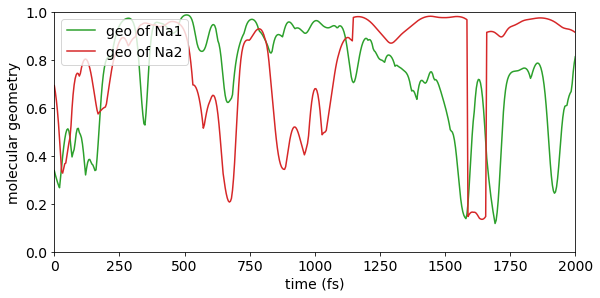

In [5]:
plt.figure(figsize=(16,12))
plt.subplot(3,2,1)
plt.plot(mol_geo[:,0], mol_geo[:,1], label='geo of Na1', color='C2')
plt.plot(mol_geo[:,0], mol_geo[:,2], label='geo of Na2', color='C3')
plt.legend(loc=2)
plt.ylabel('molecular geometry')
plt.ylim([0,1])
plt.xlim([0,2000])
plt.xlabel('time (fs)')



plt.tight_layout()

<IPython.core.display.Javascript object>


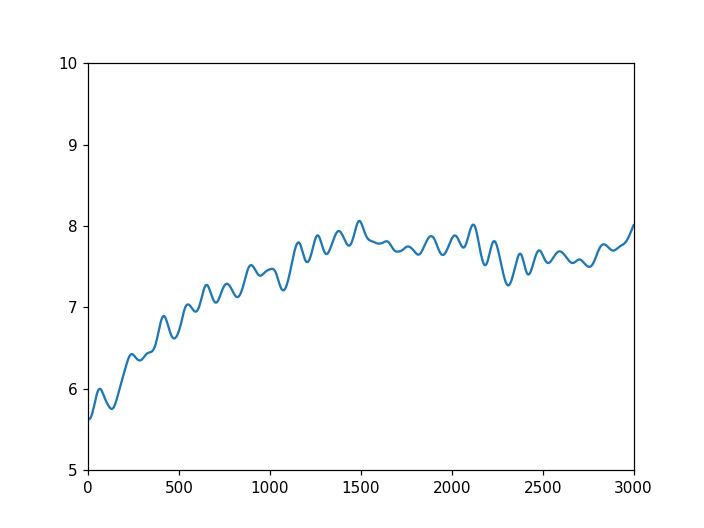

(0.0, 3000.0)

In [16]:
#4,5 cluster traj 1 - 20
%matplotlib notebook
root = '/u/home/k/kmei94/project-schwartz/Na2/dynamic/cluster/55/'
dirs = np.arange(20,21)

for i in dirs:
    my_dir = root+str(i)
    
    bond_dist = np.loadtxt(my_dir+'/bondumb2.out')
    plt.plot(bond_dist[:,0], bond_dist[:,1])

plt.ylim([5,10])
plt.xlim([0,3000])